#Customer_Churn_Prediction

In [ ]:
# Install necessary libraries
!pip install scikit-learn xgboost imbalanced-learn --quiet

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Set aesthetic styles
sns.set(style="whitegrid")

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Preview the data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [ ]:
# Remove empty spaces in TotalCharges and convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", np.nan))

# Drop rows with missing TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

# Drop customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

# Reset index after drop
df.reset_index(drop=True, inplace=True)

print("Missing values after cleanup:")
print(df.isnull().sum())

Missing values after cleanup:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [ ]:
# Convert Churn column to binary: Yes -> 1, No -> 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0}).astype(int)

Churn Distribution:
 Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


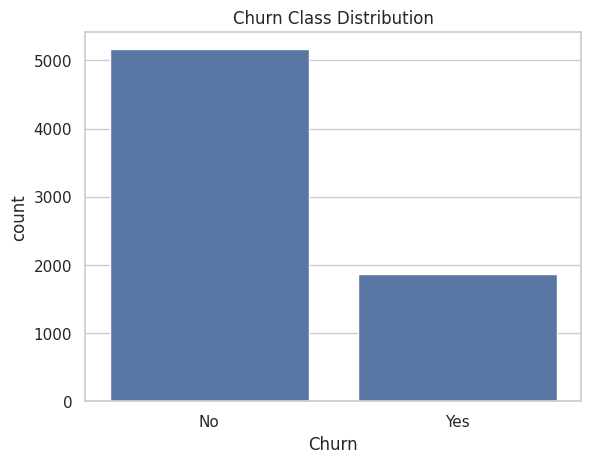

In [ ]:
churn_counts = df['Churn'].value_counts(normalize=True)
print("Churn Distribution:\n", churn_counts)

# Plot class distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Class Distribution")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [ ]:
# Identify categorical columns
cat_cols = df.select_dtypes(include='object').columns

# One-hot encoding with drop_first=True
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [ ]:
# Standardize numeric columns
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

In [ ]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

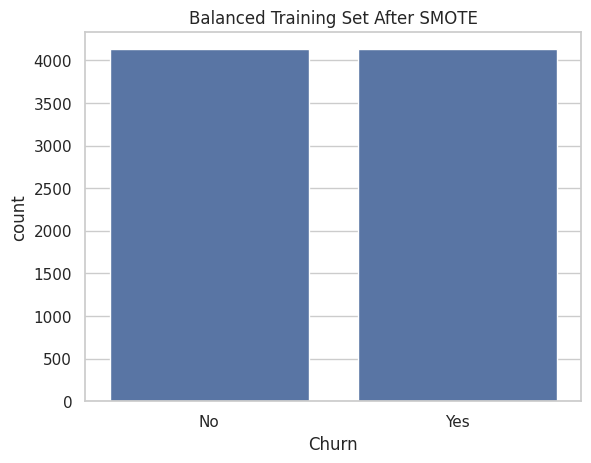

In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Plot new class distribution
sns.countplot(x=y_train_bal)
plt.title("Balanced Training Set After SMOTE")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

#Train Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_bal, y_train_bal)
y_pred_logreg = logreg.predict(X_test)

🔍 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.73      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.74      0.76      1407



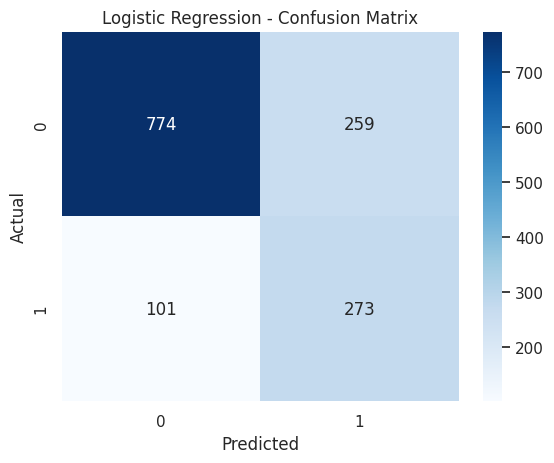

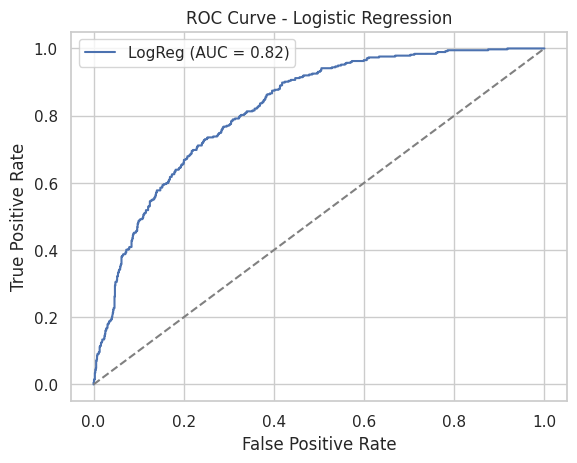

In [ ]:
print("🔍 Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_logreg)
roc_auc = roc_auc_score(y_test, y_proba_logreg)

plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#Train Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test)

🌳 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1033
           1       0.57      0.65      0.61       374

    accuracy                           0.78      1407
   macro avg       0.72      0.74      0.73      1407
weighted avg       0.79      0.78      0.78      1407



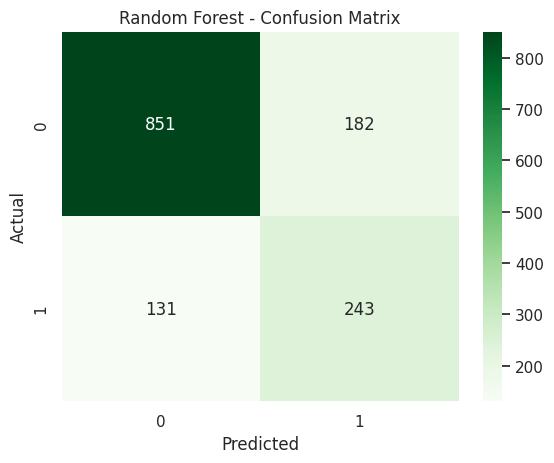

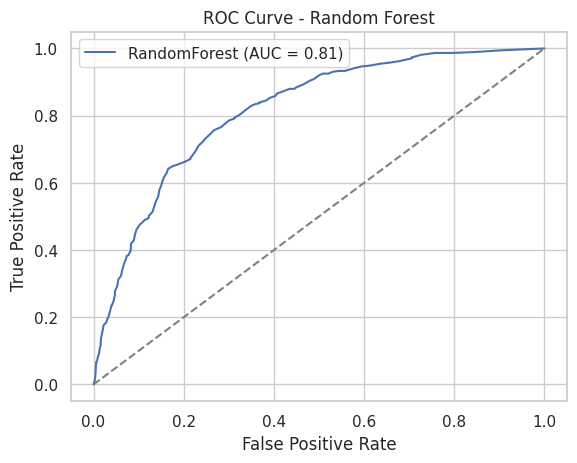

In [ ]:
print("🌳 Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_proba_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#Train XGBoost

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test)

🔥 XGBoost Performance:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1033
           1       0.54      0.66      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.78      0.76      0.76      1407



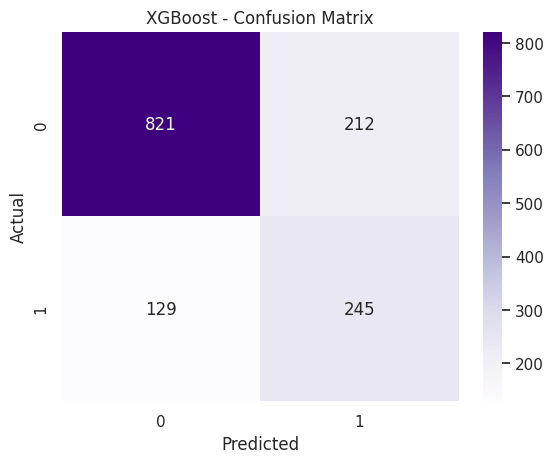

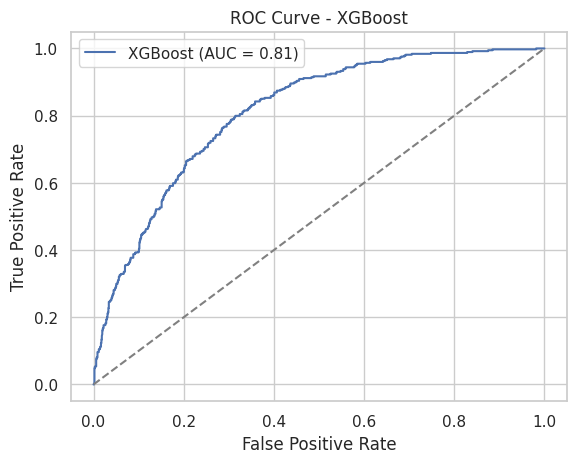

In [ ]:
print("🔥 XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Purples')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#Feature Importance (XGBoost)

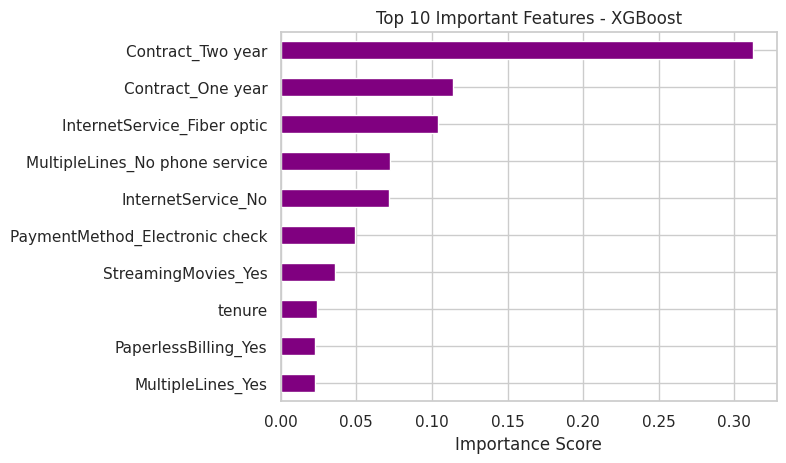

In [ ]:
# Plot top 10 features
xgb_feat_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

xgb_feat_imp.plot(kind='barh', color='purple')
plt.title("Top 10 Important Features - XGBoost")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Pick a random customer from the test set
sample = X_test.sample(1, random_state=42)
true_label = y_test.loc[sample.index].values[0]
pred_proba = xgb.predict_proba(sample)[0][1]
pred_label = xgb.predict(sample)[0]

# Create a pretty print block
print("🧪 Sample Customer Churn Prediction\n" + "-"*40)
print("📌 Features:")
display(sample)  # This will show the sample features in Jupyter

print("🔮 Model Prediction Summary:")
print(f"🔢 Churn Probability: {pred_proba:.2f}")
print(f"📤 Predicted: {'Yes' if pred_label else 'No'}")
print(f"📥 Actual: {'Yes' if true_label else 'No'}")

# Optional: Highlight if prediction is correct
if pred_label == true_label:
    print("✅ Prediction is CORRECT!")
else:
    print("❌ Prediction is WRONG!")

🧪 Sample Customer Churn Prediction
----------------------------------------
📌 Features:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6959,0,-1.158016,0.317506,-0.890294,True,False,False,True,False,True,...,False,False,False,False,False,False,True,False,True,False


🔮 Model Prediction Summary:
🔢 Churn Probability: 0.94
📤 Predicted: Yes
📥 Actual: Yes
✅ Prediction is CORRECT!


In [ ]:
import random

# Pick a random customer from the test set (NO random_state this time)
sample = X_test.sample(1)
true_label = y_test.loc[sample.index].values[0]

# Store predictions
model_results = {}

# Logistic Regression
logreg_pred = logreg.predict(sample)[0]
logreg_proba = logreg.predict_proba(sample)[0][1]
model_results['Logistic Regression'] = (logreg_pred, logreg_proba)

# Random Forest
rf_pred = rf.predict(sample)[0]
rf_proba = rf.predict_proba(sample)[0][1]
model_results['Random Forest'] = (rf_pred, rf_proba)

# XGBoost
xgb_pred = xgb.predict(sample)[0]
xgb_proba = xgb.predict_proba(sample)[0][1]
model_results['XGBoost'] = (xgb_pred, xgb_proba)

# Display sample customer
print("🧪 Sample Customer Churn Prediction\n" + "-"*40)
print("📌 Sample Features:")
display(sample)

# Display predictions from all models
print("\n🔮 Model Predictions:\n" + "-"*40)
for model, (pred, proba) in model_results.items():
    status = "Yes" if pred == 1 else "No"
    print(f"{model}:")
    print(f"   🔢 Churn Probability: {proba:.2f}")
    print(f"   📤 Predicted: {status}")
    print()

# Actual label
actual_status = "Yes" if true_label == 1 else "No"
print("📥 Actual Churn Label:", actual_status)
print("-" * 40)

# Summary of correctness
for model, (pred, _) in model_results.items():
    correct = "✅ Correct" if pred == true_label else "❌ Wrong"
    print(f"{model} Prediction: {correct}")


🧪 Sample Customer Churn Prediction
----------------------------------------
📌 Sample Features:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5817,0,-1.280248,0.483708,-0.972355,False,True,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False



🔮 Model Predictions:
----------------------------------------
Logistic Regression:
   🔢 Churn Probability: 0.78
   📤 Predicted: Yes

Random Forest:
   🔢 Churn Probability: 0.80
   📤 Predicted: Yes

XGBoost:
   🔢 Churn Probability: 0.97
   📤 Predicted: Yes

📥 Actual Churn Label: Yes
----------------------------------------
Logistic Regression Prediction: ✅ Correct
Random Forest Prediction: ✅ Correct
XGBoost Prediction: ✅ Correct


In [ ]:
from sklearn.metrics import classification_report

# Store predictions in dict
model_predictions = {
    'Logistic Regression': y_pred_logreg,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

print("🎯 CLASSIFICATION REPORTS\n" + "-"*35)
for name, preds in model_predictions.items():
    print(f"\n📌 {name}:\n")
    print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))


🎯 CLASSIFICATION REPORTS
-----------------------------------

📌 Logistic Regression:

              precision    recall  f1-score   support

    No Churn       0.88      0.75      0.81      1033
       Churn       0.51      0.73      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.74      0.76      1407


📌 Random Forest:

              precision    recall  f1-score   support

    No Churn       0.87      0.82      0.84      1033
       Churn       0.57      0.65      0.61       374

    accuracy                           0.78      1407
   macro avg       0.72      0.74      0.73      1407
weighted avg       0.79      0.78      0.78      1407


📌 XGBoost:

              precision    recall  f1-score   support

    No Churn       0.86      0.79      0.83      1033
       Churn       0.54      0.66      0.59       374

    accuracy                           0.76      1407
   macro a

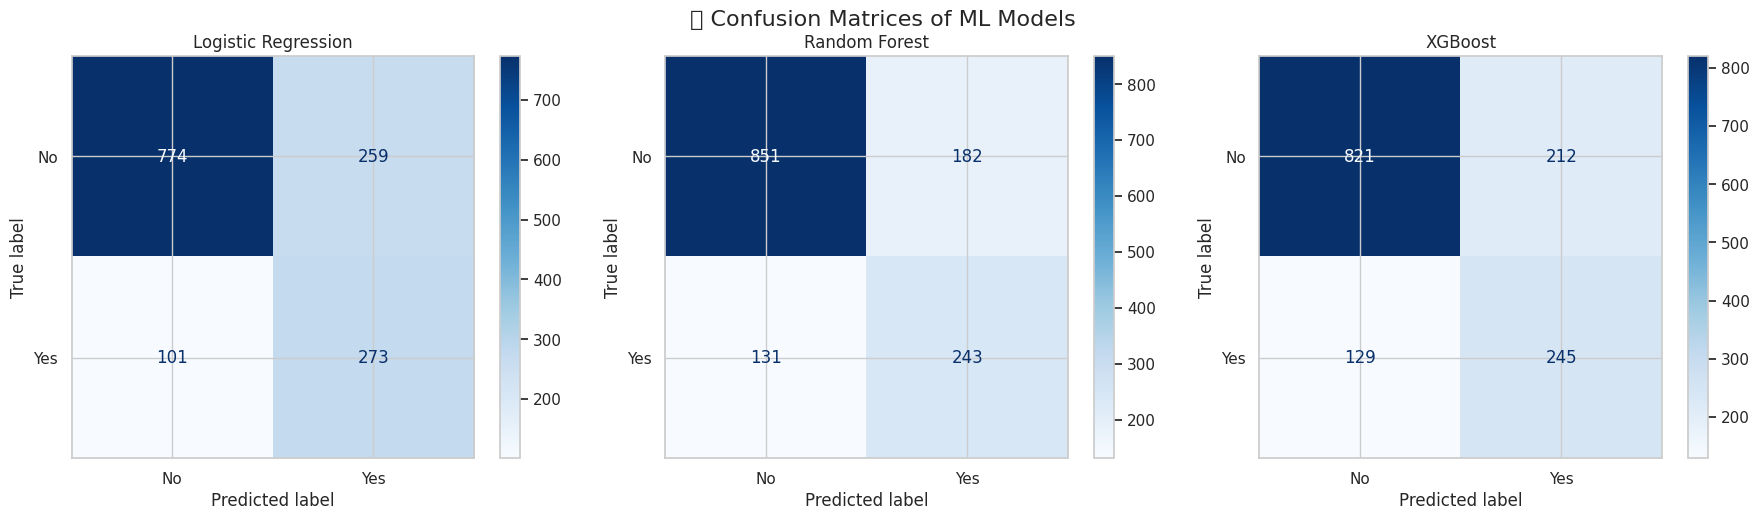

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot all confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, preds) in zip(axes, model_predictions.items()):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{name}")
plt.suptitle('📊 Confusion Matrices of ML Models', fontsize=16)
plt.tight_layout()
plt.show()

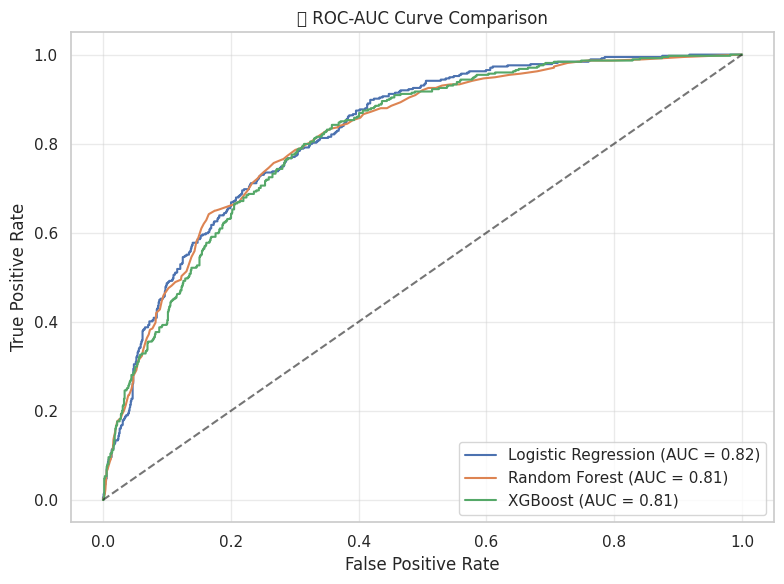

In [ ]:
from sklearn.metrics import roc_curve, auc

# Probabilities
logreg_probs = logreg.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

# Compute AUC
auc_log = auc(fpr_log, tpr_log)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.title('📈 ROC-AUC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

def get_metrics(name, y_true, y_pred, y_proba):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC': auc(*roc_curve(y_true, y_proba)[:2])
    }

# Apply formatting only to numeric columns, ignore 'Model'
leaderboard_df.style.background_gradient(cmap='YlGnBu').format({
    'Accuracy': "{:.2f}",
    'Precision': "{:.2f}",
    'Recall': "{:.2f}",
    'F1-Score': "{:.2f}",
    'AUC': "{:.2f}"
})


import pandas as pd
leaderboard_df = pd.DataFrame(leaderboard).sort_values(by='F1-Score', ascending=False)
print("🏆 Model Leaderboard")
display(leaderboard_df.style.background_gradient(cmap='YlGnBu').format({
    'Accuracy': "{:.2f}",
    'Precision': "{:.2f}",
    'Recall': "{:.2f}",
    'F1-Score': "{:.2f}",
    'AUC': "{:.2f}"
}))


🏆 Model Leaderboard


,Model,Accuracy,Precision,Recall,F1-Score,AUC
1,Random Forest,0.78,0.57,0.65,0.61,0.81
0,Logistic Regression,0.74,0.51,0.73,0.60,0.82
2,XGBoost,0.76,0.54,0.66,0.59,0.81
